## Imports

In [27]:
from nb_utils import set_root

PROJECT_DIR = set_root(4)

In [28]:
import warnings
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import ParameterGrid, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm

from src.mlpr.ml.supervisioned.classification.metrics import \
    ClassificationMetrics
from src.mlpr.ml.supervisioned.classification.utils import generate_colors

warnings.filterwarnings("ignore")

%reload_ext autoreload

## Parameters

In [29]:
target_true: str = "label_true"
target_pred: str = "label_pred"

In [30]:
random_state: int = 42

In [31]:
split: dict[str, dict[str, any]] = {
    "test_size": 0.2,
    "random_state": random_state
}

In [32]:
np.random.seed(random_state)

In [33]:
models: dict[BaseEstimator, dict] = {
    RandomForestClassifier: {
        'n_estimators': [100],
        'max_depth': [None, 10],
        'random_state': [random_state]
    },
    GradientBoostingClassifier: {
        'n_estimators': [100],
        'learning_rate': [0.1],
        'random_state': [random_state]
    },
    LogisticRegression: {
        'C': [1.0],
        'penalty': ['l2'],
        'random_state': [random_state],
    },
    GaussianNB: {
        'var_smoothing': [1e-9]
    },
    SVC: {
        'C': [1.0],
        'kernel': ['rbf'],
        'random_state': [random_state]
    },
    DecisionTreeClassifier: {
        'criterion': ['gini'],
        'max_depth': [None, 10],
        'random_state': [random_state]
    }
}

## Methods

In [34]:
def transform_with_pca(X: pd.DataFrame, **kwargs) -> pd.DataFrame:
    """
    Transform a DataFrame using PCA.

    Parameters
    ----------
    X : pandas.DataFrame
        The DataFrame to transform.

    Returns
    -------
    pandas.DataFrame
        The transformed DataFrame.
    """
    pca = PCA(**kwargs)
    transformed: np.ndarray = pca.fit_transform(X)
    return transformed

In [35]:
def accuracy(y_true: np.ndarray, y_pred: np.ndarray, **kwargs) -> float:
    """
    Compute the custom accuracy score.
    """
    return accuracy_score(y_true, y_pred, **kwargs)

## Read dataset

In [36]:
content = load_breast_cancer()
data: np.ndarray = content["data"]
features: list = content["feature_names"]
labels: np.array = content["target"]

## Get X and Y

In [37]:
X: np.ndarray = data
y: np.array = labels

In [38]:
X.shape, y.shape

((569, 30), (569,))

## Transform dataset

In [39]:
X_pca = transform_with_pca(X, n_components=2)

## Split dataset

In [40]:
X_train, X_test, y_train, y_test = train_test_split(
    X_pca,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

## Dataset behavior

In [41]:
folds: dict[str, dict[str, any]] = {
    "dataset": {
        "X": X_pca,
        "y": y,
        "graph": {}
    },
    "train": {
        "X": X_train,
        "y": y_train,
        "graph": {}
    },
    "test": {
        "X": X_test,
        "y": y_test,
        "graph": {}
    }
}

In [42]:
centers: dict = {
    state: {k: fold["X"][fold["y"] == k].mean(axis=0) for k in np.unique(fold["y"])} for state, fold in folds.items()
}

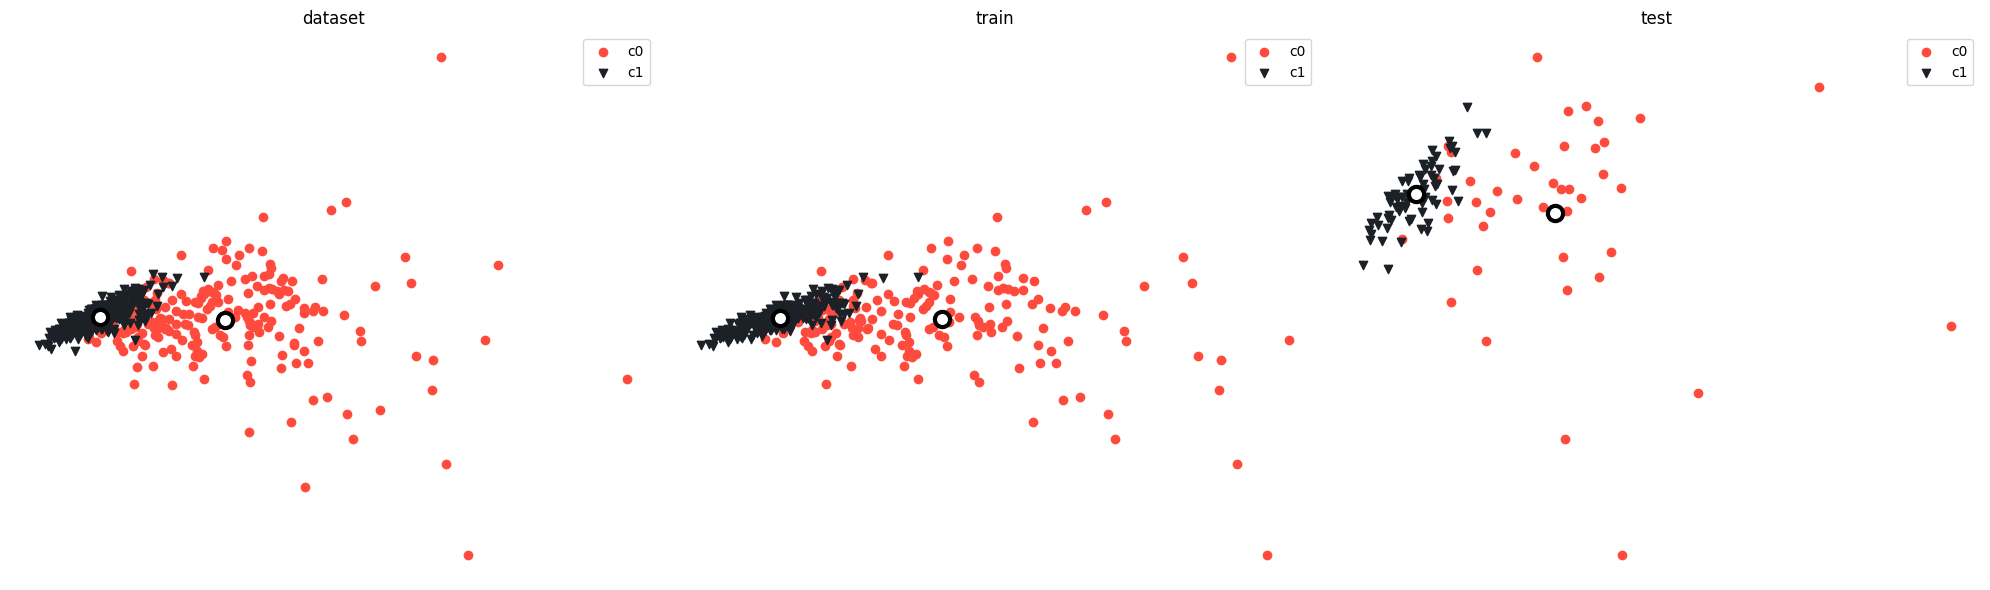

In [43]:
markers: list[str] = ['o', 'v']
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

colors: list = generate_colors("FF4B3E", "1C2127", len(np.unique(y)))

for idx, (state, fold) in enumerate(folds.items()):
    for i, k in enumerate(np.unique(y)):
        ax[idx].scatter(
            fold["X"][:, 0][fold["y"] == k],
            fold["X"][:, 1][fold["y"] == k],
            marker=markers[i % len(markers)],
            color=colors[i],
            label=f"c{i}",
            **fold["graph"]
        )
    ax[idx].legend()

    ax[idx].set_title(state)
    ax[idx].set_frame_on(False)
    ax[idx].set_xticks([])
    ax[idx].set_yticks([])
    for center in centers[state].values():
        ax[idx].scatter(
            center[0],
            center[1],
            color="white",
            linewidths=3,
            marker="o",
            edgecolor="black",
            s=120
        )
#
plt.legend()
fig.tight_layout()

## Training a Random Forest

In [44]:
clf = RandomForestClassifier(random_state=random_state)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

## Evaluation the model

In [45]:
metrics = ClassificationMetrics(
    {
        "accuracy_score": {},
        "precision_score": {"average": "macro"},
        "recall_score": {"average": "macro"},
        "f1_score": {"average": "macro"},
        "confusion_matrix": {}
    }
)

metrics.compute_metrics(y_test, y_pred)

print(metrics.results_)

{'accuracy_score': [0.9210526315789473], 'precision_score': [0.913691451031772], 'recall_score': [0.9176587301587302], 'f1_score': [0.9155902920608803], 'confusion_matrix': array([[38,  4],
       [ 5, 67]])}


In [46]:
metrics.results_["confusion_matrix"] = [metrics.results_["confusion_matrix"]]

In [47]:
pd.DataFrame(metrics.results_)

,accuracy_score,precision_score,recall_score,f1_score,confusion_matrix
0,0.921053,0.913691,0.917659,0.91559,"[[38, 4], [5, 67]]"


## Calculate a custom metric

In [48]:
metrics = ClassificationMetrics(
    {
        "custom_accuracy": {}
    }
)
metrics.add_metric("custom_accuracy", partial(accuracy, normalize=False))

metrics.compute_metrics(y_test, y_pred)

print(metrics.results_)

{'custom_accuracy': [105.0]}


## Training multiples models

In [49]:
trained_models: dict = {}
for model, params in tqdm(models.items()):
    param_grid = ParameterGrid(params)
    for param_combination in tqdm(param_grid):
        model_instance: BaseEstimator = model(**param_combination)
        model_instance.fit(X_train, y_train)
        model_name: str = f"{model.__name__}_{str(param_combination)}"
        model_name: str = (
            model_name
            .replace("{}", "")
            .replace("{", "_")
            .replace("}", "_")
            .replace("'", "")
            .replace(": ", "_")
            .replace(", ", "_")
            .replace(".", "_")
        )
        if "_" in model_name[-1]:
            model_name = model_name[:(-1)]
        trained_models[model_name] = model_instance

100%|██████████| 6/6 [00:01<00:00,  3.29it/s]


## Evaluation models

In [50]:
dict_metrics: dict[str, dict] = {
    "accuracy_score": {},
    "precision_score": {"average": "macro"},
    "recall_score": {"average": "macro"},
    "f1_score": {"average": "macro"},
    "confusion_matrix": {}
}
metrics = ClassificationMetrics(dict_metrics)

In [51]:
results = pd.DataFrame(
    columns=dict_metrics.keys()
)
for name, model in trained_models.items():
    y_pred = model.predict(X_test)
    metrics.compute_metrics(y_test, y_pred)
    metrics.results_["confusion_matrix"] = [metrics.results_["confusion_matrix"]]
    results: pd.DataFrame = pd.concat(
        [
            results, pd.DataFrame(metrics.results_, index=[name])
        ]
    )

In [52]:
results

,accuracy_score,precision_score,recall_score,f1_score,confusion_matrix
RandomForestClassifier__max_depth_None_n_estimators_100_random_state_42,0.921053,0.913691,0.917659,0.915590,"[[38, 4], [5, 67]]"
RandomForestClassifier__max_depth_10_n_estimators_100_random_state_42,0.929825,0.924603,0.924603,0.924603,"[[38, 4], [4, 68]]"
GradientBoostingClassifier__learning_rate_0_1_n_estimators_100_random_state_42,0.921053,0.913691,0.917659,0.915590,"[[38, 4], [5, 67]]"
LogisticRegression__C_1_0_penalty_l2_random_state_42,0.938596,0.941026,0.926587,0.932981,"[[37, 5], [2, 70]]"
GaussianNB__var_smoothing_1e-09,0.903509,0.907511,0.883929,0.893467,"[[34, 8], [3, 69]]"
SVC__C_1_0_kernel_rbf_random_state_42,0.921053,0.921538,0.907738,0.913832,"[[36, 6], [3, 69]]"
DecisionTreeClassifier__criterion_gini_max_depth_None_random_state_42,0.894737,0.886905,0.886905,0.886905,"[[36, 6], [6, 66]]"
DecisionTreeClassifier__criterion_gini_max_depth_10_random_state_42,0.885965,0.878884,0.875000,0.876859,"[[35, 7], [6, 66]]"
